# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [266]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [267]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [268]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()
signals_df

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [269]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [270]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [271]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [272]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot: xlabel='date'>

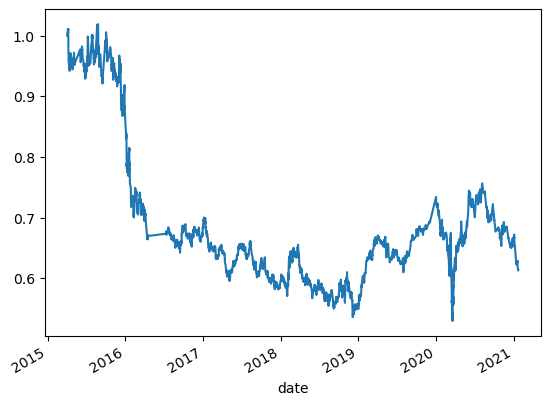

In [273]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [274]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [275]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [276]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [277]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [278]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [279]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [280]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [281]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [282]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [283]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

In [284]:
print(len(signals_df))
print(len(predictions_df))

4223
4092


In [285]:
print(signals_df.index.equals(predictions_df.index))
print(len(signals_df) == len(predictions_df))

False
False


In [286]:
print(signals_df.index)
print(predictions_df.index)

DatetimeIndex(['2015-04-02 14:45:00', '2015-04-02 15:00:00',
               '2015-04-02 15:15:00', '2015-04-02 15:30:00',
               '2015-04-02 15:45:00', '2015-04-06 09:30:00',
               '2015-04-06 09:45:00', '2015-04-06 10:15:00',
               '2015-04-06 11:45:00', '2015-04-06 12:00:00',
               ...
               '2021-01-14 15:45:00', '2021-01-19 09:30:00',
               '2021-01-19 11:15:00', '2021-01-19 12:30:00',
               '2021-01-20 09:45:00', '2021-01-22 09:30:00',
               '2021-01-22 11:30:00', '2021-01-22 13:45:00',
               '2021-01-22 14:30:00', '2021-01-22 15:45:00'],
              dtype='datetime64[ns]', name='date', length=4223, freq=None)
DatetimeIndex(['2015-07-06 10:00:00', '2015-07-06 10:45:00',
               '2015-07-06 14:15:00', '2015-07-06 14:30:00',
               '2015-07-07 11:30:00', '2015-07-07 13:45:00',
               '2015-07-07 15:00:00', '2015-07-07 15:45:00',
               '2015-07-08 10:00:00', '2015-07-08 1

In [287]:
print(signals_df.index.equals(predictions_df.index))
print(len(signals_df) == len(predictions_df))

False
False


In [383]:
# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (signals_df["Actual Returns"] * predictions_df["Predicted"])

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot: xlabel='date'>

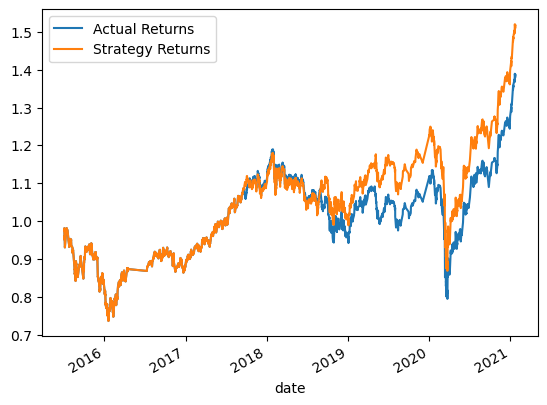

In [384]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()


---

## Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

In [436]:
training_endnew = X.index.min() + DateOffset(months=5)

# Display the training end date
print(training_endnew)

2016-01-12 13:15:00


In [437]:
#X_train DataFrame
X_trainn = X.loc[training_begin:training_endnew]
y_trainn = y.loc[training_begin:training_endnew]

X_trainn.head()
X_trainn.tail()

,SMA_Fast,SMA_Slow
date,,
2016-01-11 12:00:00,18.774,19.9217
2016-01-11 13:00:00,18.758,19.9101
2016-01-11 13:15:00,18.728,19.8938
2016-01-11 15:45:00,18.694,19.8777
2016-01-12 10:00:00,18.682,19.8645


In [438]:
X_trainn.shape

(364, 2)

In [439]:
#X_test DataFrame
X_testn = X.loc[training_endnew+DateOffset(hours=1):]
y_testn = y.loc[training_endnew+DateOffset(hours=1):]

X_testn.head()

,SMA_Fast,SMA_Slow
date,,
2016-01-12 15:45:00,18.682,19.8362
2016-01-13 13:30:00,18.682,19.8219
2016-01-13 13:45:00,18.670,19.8063
2016-01-13 14:45:00,18.665,19.7905
2016-01-14 12:00:00,18.650,19.7744


In [440]:
X_testn.shape

(3659, 2)

In [441]:
# Transform X_train and X_test DataFrames using the X_scaler
scaler = StandardScaler()

X_scalern = scaler.fit(X_trainn)

X_train_scaledn = X_scalern.transform(X_trainn)
X_test_scaledn = X_scalern.transform(X_testn)

In [442]:
#Fitting the model to Data using trained data and testing it/reviewing model predictd values
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaledn, y_trainn)
svm_predn =  svm_model.predict(X_test_scaledn)
svm_predn[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [443]:
#print report
svm_testing_reportn = classification_report(y_testn, svm_predn)
print(svm_testing_reportn)

              precision    recall  f1-score   support

        -1.0       0.41      0.04      0.08      1592
         1.0       0.56      0.95      0.71      2067

    accuracy                           0.56      3659
   macro avg       0.49      0.50      0.39      3659
weighted avg       0.50      0.56      0.43      3659



In [444]:
predictions_dfn = pd.DataFrame(index=X_testn.index)

In [445]:
#Add actual and strategy returns to data frame
predictions_dfn["predicted_signaln"] = svm_predn
predictions_dfn["Actual Returnsn"] = signals_df["Actual Returns"]
predictions_dfn["Strategy Returnsn"] = (signals_df["Actual Returns"] * predictions_dfn["predicted_signaln"])
predictions_dfn.head()

,predicted_signaln,Actual Returnsn,Strategy Returnsn
date,,,
2016-01-12 15:45:00,-1.0,0.003212,-0.003212
2016-01-13 13:30:00,-1.0,-0.005870,0.005870
2016-01-13 13:45:00,-1.0,-0.000537,0.000537
2016-01-13 14:45:00,-1.0,-0.005371,0.005371
2016-01-14 12:00:00,-1.0,0.010259,-0.010259


<AxesSubplot: xlabel='date'>

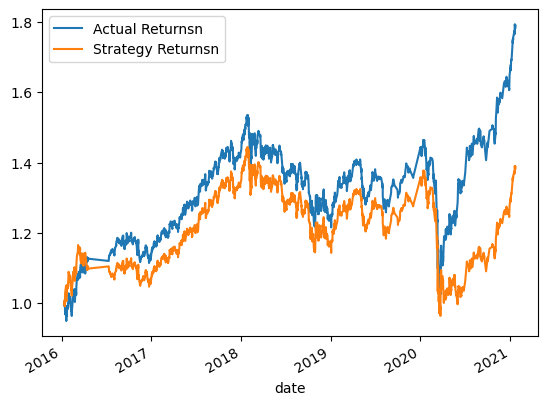

In [446]:
(1 + predictions_dfn[["Actual Returnsn", "Strategy Returnsn"]]).cumprod().plot()

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

In [447]:
short_window = 10
long_window = 100
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2015-10-07 15:45:00,22.20,0.000902,22.176,21.47869,1.0,-0.000902,-0.000902
2015-10-08 09:45:00,22.26,0.002703,22.231,21.47979,1.0,0.002703,0.002703
2015-10-08 10:00:00,22.28,0.000898,22.237,21.48149,1.0,0.000898,0.000898
2015-10-08 10:45:00,22.26,-0.000898,22.224,21.48279,-1.0,-0.000898,-0.000898
2015-10-08 11:00:00,22.12,-0.006289,22.211,21.48269,-1.0,0.006289,0.006289


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,30.40215,-1.0,-0.006866,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.014,30.44445,1.0,-0.002405,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.098,30.48745,1.0,0.002099,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.170,30.53085,1.0,0.001496,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.57495,-1.0,-0.000896,-0.000896


In [448]:
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2015-10-07 15:45:00,22.20,0.000902,22.176,21.47869,1.0,-0.000902,-0.000902
2015-10-08 09:45:00,22.26,0.002703,22.231,21.47979,1.0,0.002703,0.002703
2015-10-08 10:00:00,22.28,0.000898,22.237,21.48149,1.0,0.000898,0.000898
2015-10-08 10:45:00,22.26,-0.000898,22.224,21.48279,-1.0,-0.000898,-0.000898
2015-10-08 11:00:00,22.12,-0.006289,22.211,21.48269,-1.0,0.006289,0.006289


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,30.40215,-1.0,-0.006866,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.014,30.44445,1.0,-0.002405,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.098,30.48745,1.0,0.002099,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.170,30.53085,1.0,0.001496,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.57495,-1.0,-0.000896,-0.000896


In [449]:
signals_df['Signal'].value_counts()

 1.0    2202
-1.0    1724
Name: Signal, dtype: int64

In [450]:
signals_df['Strategy Returnsf'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2015-10-07 15:45:00,22.20,0.000902,22.176,21.47869,1.0,-0.000902,NaN
2015-10-08 09:45:00,22.26,0.002703,22.231,21.47979,1.0,0.002703,0.002703
2015-10-08 10:00:00,22.28,0.000898,22.237,21.48149,1.0,0.000898,0.000898
2015-10-08 10:45:00,22.26,-0.000898,22.224,21.48279,-1.0,-0.000898,-0.000898
2015-10-08 11:00:00,22.12,-0.006289,22.211,21.48269,-1.0,0.006289,0.006289


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Strategy Returnsf
date,,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.930,30.40215,-1.0,-0.006866,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.014,30.44445,1.0,-0.002405,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.098,30.48745,1.0,0.002099,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.170,30.53085,1.0,0.001496,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.249,30.57495,-1.0,-0.000896,-0.000896


<AxesSubplot: xlabel='date'>

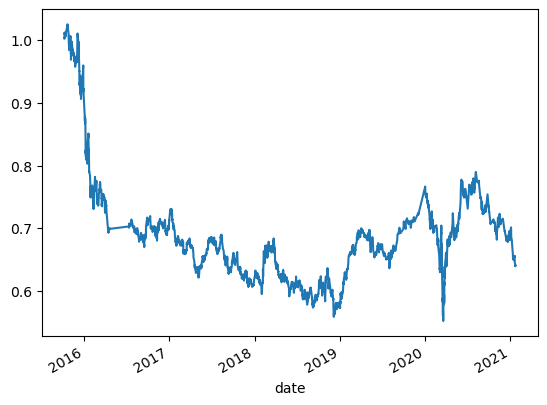

In [451]:
(1 + signals_df['Strategy Returnsf']).cumprod().plot()

In [452]:
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

X.head()

,SMA_Fast,SMA_Slow
date,,
2015-10-08 09:45:00,22.176,21.47869
2015-10-08 10:00:00,22.231,21.47979
2015-10-08 10:45:00,22.237,21.48149
2015-10-08 11:00:00,22.224,21.48279
2015-10-08 11:30:00,22.211,21.48269


In [453]:
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2202
-1.0    1724
Name: Signal, dtype: int64

In [454]:
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-10-08 09:45:00


In [455]:
training_end = X.index.min() + DateOffset(months=5)

# Display the training end date
print(training_end)

2016-03-08 09:45:00


In [456]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-10-08 09:45:00,22.176,21.47869
2015-10-08 10:00:00,22.231,21.47979
2015-10-08 10:45:00,22.237,21.48149
2015-10-08 11:00:00,22.224,21.48279
2015-10-08 11:30:00,22.211,21.48269


In [457]:
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2016-03-08 12:00:00,19.676,18.9250
2016-03-08 14:45:00,19.742,18.9403
2016-03-08 15:45:00,19.815,18.9564
2016-03-09 12:00:00,19.902,18.9719
2016-03-10 14:15:00,19.962,18.9881


In [458]:
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [459]:
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_predf =  svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_predf[:10]

array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [460]:
svm_testing_reportf = classification_report(y_test, svm_predf)

# Print the classification report
print(svm_testing_reportf)

              precision    recall  f1-score   support

        -1.0       0.42      0.17      0.24      1523
         1.0       0.56      0.82      0.67      1974

    accuracy                           0.54      3497
   macro avg       0.49      0.49      0.45      3497
weighted avg       0.50      0.54      0.48      3497



In [461]:
predictions_dff = pd.DataFrame(index=X_test.index)

In [462]:
predictions_dff["predicted_signalf"] = svm_predf
# Add the actual returns to the DataFrame
predictions_dff["Actual Returnsf"] = signals_df["Actual Returns"]
# Add the strategy returns to the DataFrame
predictions_dff["Strategy Returnsf"] = (signals_df["Actual Returns"] * predictions_dff["predicted_signalf"])

# Review the DataFrame
predictions_dff.head()

,predicted_signalf,Actual Returnsf,Strategy Returnsf
date,,,
2016-03-08 12:00:00,1.0,-0.001503,-0.001503
2016-03-08 14:45:00,-1.0,0.002509,-0.002509
2016-03-08 15:45:00,-1.0,0.000501,-0.000501
2016-03-09 12:00:00,-1.0,0.007004,-0.007004
2016-03-10 14:15:00,-1.0,-0.005961,0.005961


<AxesSubplot: xlabel='date'>

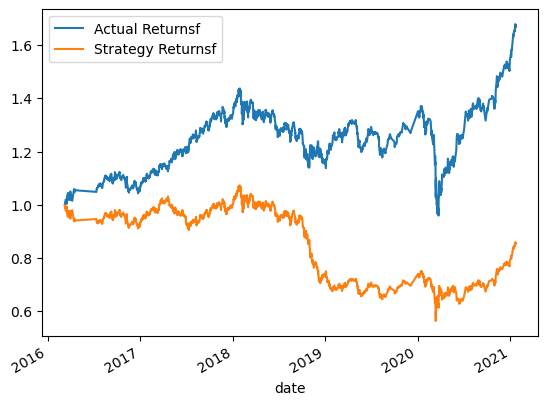

In [463]:
(1 + predictions_dff[["Actual Returnsf", "Strategy Returnsf"]]).cumprod().plot()

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [464]:
training_end2 = X.index.min() + DateOffset(months=5)
print(training_end2)

2016-03-08 09:45:00


In [465]:
X_train2 = X.loc[training_begin:training_end2]
y_train2 = y.loc[training_begin:training_end2]

# Review the X_train DataFrame
X_train2.head()
X_train2.tail()

,SMA_Fast,SMA_Slow
date,,
2016-03-01 15:45:00,19.183,18.8486
2016-03-03 14:30:00,19.230,18.8603
2016-03-07 12:45:00,19.323,18.8758
2016-03-07 15:45:00,19.440,18.8930
2016-03-08 09:45:00,19.583,18.9094


In [466]:
X_train2.shape

(428, 2)

In [467]:
X_test2 = X.loc[training_end2+DateOffset(hours=1):]
y_test2 = y.loc[training_end2+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test2.head()

,SMA_Fast,SMA_Slow
date,,
2016-03-08 12:00:00,19.676,18.9250
2016-03-08 14:45:00,19.742,18.9403
2016-03-08 15:45:00,19.815,18.9564
2016-03-09 12:00:00,19.902,18.9719
2016-03-10 14:15:00,19.962,18.9881


In [468]:
X_test2.shape

(3497, 2)

In [469]:
X_test2 = X.loc[training_end2+DateOffset(hours=1):]
y_test2 = y.loc[training_end2+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test2.head()

,SMA_Fast,SMA_Slow
date,,
2016-03-08 12:00:00,19.676,18.9250
2016-03-08 14:45:00,19.742,18.9403
2016-03-08 15:45:00,19.815,18.9564
2016-03-09 12:00:00,19.902,18.9719
2016-03-10 14:15:00,19.962,18.9881


In [470]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [471]:
# Fit the model using the training data
model = logistic_regression_model.fit(X_train2, y_train2)

# Use the testing dataset to generate the predictions for the new model
pred = logistic_regression_model.predict(X_test2)

# Review the model's predicted values
pred


array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [472]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_training_report = classification_report(y_test2, pred)

# Print the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.83      0.58      1523
         1.0       0.60      0.20      0.30      1974

    accuracy                           0.47      3497
   macro avg       0.52      0.51      0.44      3497
weighted avg       0.53      0.47      0.42      3497



In [473]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df2 = pd.DataFrame(index=X_test2.index)

# Add the SVM model predictions to the DataFrame
predictions_df2["predicted_signal2"] = pred

# Add the actual returns to the DataFrame
predictions_df2["LRActual Returns2"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df2["LRStrategy Returns2"] = (
    signals_df["Actual Returns"] * predictions_df2["predicted_signal2"]
)

# Review the DataFrame
predictions_df2


,predicted_signal2,LRActual Returns2,LRStrategy Returns2
date,,,
2016-03-08 12:00:00,1.0,-0.001503,-0.001503
2016-03-08 14:45:00,1.0,0.002509,0.002509
2016-03-08 15:45:00,1.0,0.000501,0.000501
2016-03-09 12:00:00,1.0,0.007004,0.007004
2016-03-10 14:15:00,1.0,-0.005961,-0.005961
...,...,...,...
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099


<AxesSubplot: xlabel='date'>

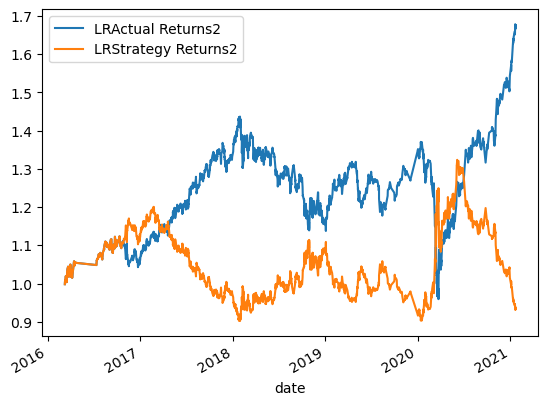

In [474]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df2[["LRActual Returns2", "LRStrategy Returns2"]]).cumprod().plot()

In [475]:
training_end3 = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end3)

2016-01-08 09:45:00


In [476]:
X_train3 = X.loc[training_begin:training_end3]
y_train3 = y.loc[training_begin:training_end3]

# Review the X_train DataFrame
X_train3.head()
X_train3.tail()

,SMA_Fast,SMA_Slow
date,,
2016-01-07 13:15:00,19.278,20.0722
2016-01-07 15:30:00,19.212,20.0600
2016-01-07 15:45:00,19.133,20.0461
2016-01-08 09:30:00,19.069,20.0365
2016-01-08 09:45:00,19.020,20.0278


In [477]:
X_train3.shape

(250, 2)

In [478]:
X_test3 = X.loc[training_end3+DateOffset(hours=1):]
y_test3 = y.loc[training_end3+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test3.head()

,SMA_Fast,SMA_Slow
date,,
2016-01-08 10:45:00,18.915,20.0114
2016-01-08 12:15:00,18.909,20.0021
2016-01-08 13:30:00,18.889,19.9942
2016-01-08 15:15:00,18.875,19.9853
2016-01-08 15:45:00,18.855,19.9750


In [479]:
X_test3.shape

(3674, 2)

In [480]:
from sklearn.ensemble import AdaBoostClassifier

In [481]:
ada = AdaBoostClassifier()

In [482]:
ada.fit(X_train3, y_train3)

# Make predictions on the testing data
ada_predictions = ada.predict(X_test3)

# Print the classification report for the AdaBoost classifier
print(classification_report(y_test3, ada_predictions))

              precision    recall  f1-score   support

        -1.0       0.44      0.83      0.57      1599
         1.0       0.57      0.17      0.26      2075

    accuracy                           0.46      3674
   macro avg       0.50      0.50      0.42      3674
weighted avg       0.51      0.46      0.40      3674



In [483]:
ada_df = pd.DataFrame(index=X_test3.index)

In [484]:
ada_df['AdaBoost Predicted'] = ada_predictions
ada_df['AdaBoost Actual Returns'] = signals_df["Actual Returns"]
ada_df['AdaBoost Strategy Returns'] = ada_df['AdaBoost Actual Returns'] * ada_df['AdaBoost Predicted']
ada_df

,AdaBoost Predicted,AdaBoost Actual Returns,AdaBoost Strategy Returns
date,,,
2016-01-08 10:45:00,-1.0,-0.001060,0.001060
2016-01-08 12:15:00,-1.0,0.002653,-0.002653
2016-01-08 13:30:00,-1.0,-0.004233,0.004233
2016-01-08 15:15:00,-1.0,-0.002125,0.002125
2016-01-08 15:45:00,-1.0,-0.004792,0.004792
...,...,...,...
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099


<AxesSubplot: xlabel='date'>

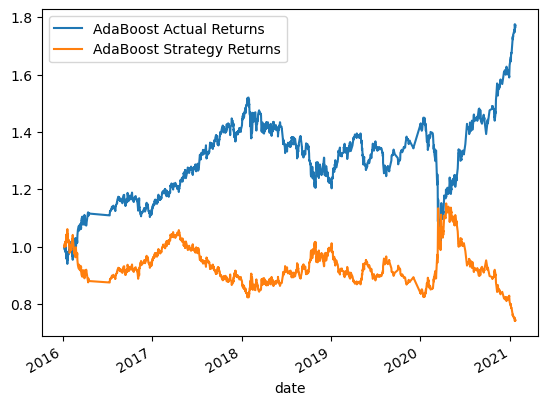

In [485]:
(1 + ada_df[["AdaBoost Actual Returns", "AdaBoost Strategy Returns"]]).cumprod().plot()

<AxesSubplot: xlabel='date'>

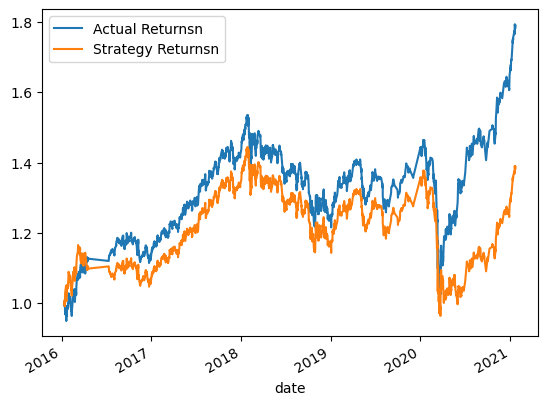

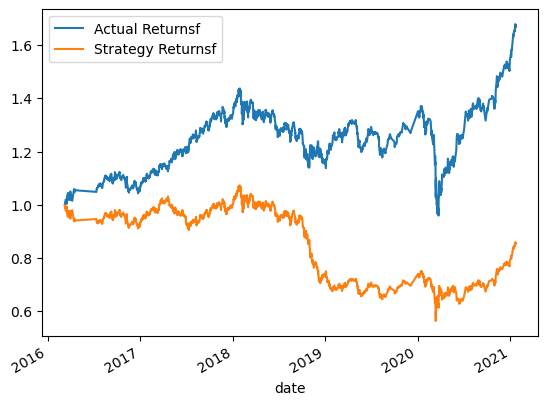

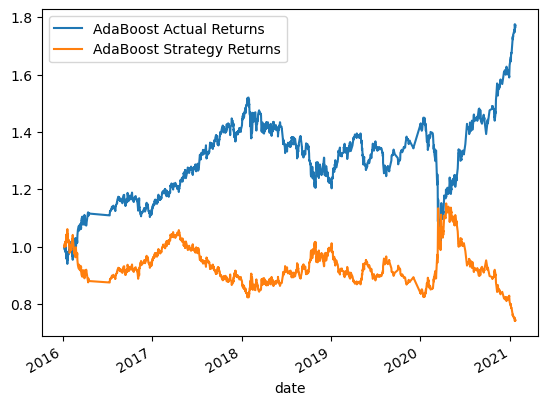

In [486]:
(1 + predictions_dfn[["Actual Returnsn", "Strategy Returnsn"]]).cumprod().plot()
(1 + predictions_dff[["Actual Returnsf", "Strategy Returnsf"]]).cumprod().plot()
(1 + ada_df[["AdaBoost Actual Returns", "AdaBoost Strategy Returns"]]).cumprod().plot()